In [8]:
!pip install keras_tuner

In [9]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np


Reloading Tuner from cifar10_tuning/cnn_tuning/tuner0.json

Best Hyperparameters:
Dropout Rates: 0.25, 0.25, 0.15000000000000002
Dense Units: 368
Dropout Dense: 0.2
Learning Rate: 0.001

Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.3540 - loss: 2.6282 - val_accuracy: 0.4190 - val_loss: 1.6925
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5135 - loss: 1.4540 - val_accuracy: 0.4569 - val_loss: 1.6232
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5665 - loss: 1.3207 - val_accuracy: 0.5287 - val_loss: 1.4190
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5877 - loss: 1.2511 - val_accuracy: 0.5947 - val_loss: 1.2459
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6133 - loss: 1.2020 - val_accuracy: 0.5889 - val_loss: 1.2458
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6281 - loss: 1.1447 - val_accuracy: 0.6089 - val_loss: 1.2212
Epoch 7/40
1563/1563 ━━━━━━━━

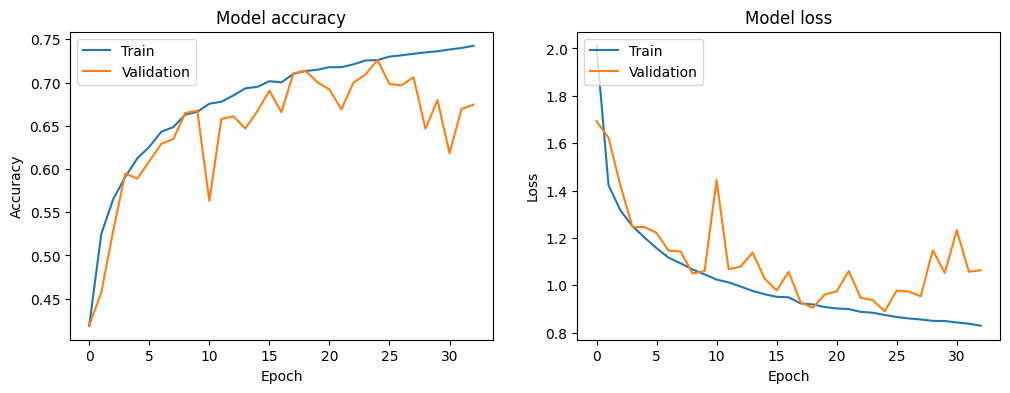

In [12]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# Combine the training and testing data
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# Split the combined data back into training and testing sets, shuffling the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=True, random_state=42)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
from tensorflow.keras.layers import BatchNormalization
# Define the model builder function for Keras Tuner
def build_model(hp):
    model = Sequential([
        Conv2D(32, (4, 4), activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.05)),

        Conv2D(128, (4, 4), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.05)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(hp.Float('dropout_3', 0.1, 0.5, step=0.05)),

        Flatten(),
        #Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

        Dense(hp.Int('dense_units', min_value=32, max_value=512, step=16), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # Added L2 regularization
        Dropout(hp.Float('dropout_dense', 0.1, 0.5, step=0.05)),

        Dense(10, activation='softmax')
    ])

    # Compile the model
    learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='cifar10_tuning',
    project_name='cnn_tuning'
)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=40, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Hyperparameters:
Dropout Rates: {best_hps.get('dropout_1')}, {best_hps.get('dropout_2')}, {best_hps.get('dropout_3')}
Dense Units: {best_hps.get('dense_units')}
Dropout Dense: {best_hps.get('dropout_dense')}
Learning Rate: {best_hps.get('learning_rate')}
""")

# Train the best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest Loss:', test_loss)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig('training_history_tuned.png')
print("Training history plot saved as 'training_history_tuned.png'")